In [16]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Curve fitting vs ODE identification

In this notebook we compare two very different approaches of data modeling. The first one consists in simply fitting a predetermined function to the data. And the second one is more inclined towards extracting the dynamics that govern the data.

## With simulated data

We will be working with the simulated data from the linear oscillator governed by:

\begin{align}
    \dot{x} & = -0.1x + 2y \\
    \dot{y} & = -2x -0.1y 
\end{align}

The trajectory has 300 points with a timestep of 0.033444816053511704


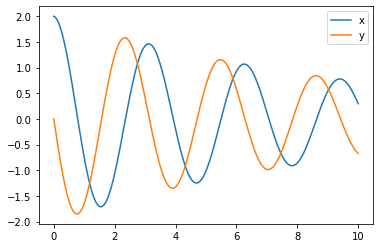

In [2]:
from scipy.optimize import curve_fit; from scipy.io import loadmat
import numpy as np; import pandas as pd; import tensorflow as tf; 
import matplotlib.pyplot as plt

data = loadmat('data/py_odes.mat')
t = data['t'][0]
data = data['linear_oscillator']

print(f'The trajectory has {len(data)} points with a timestep of {t[1]}')

for dim in range(data.shape[1]):
    plt.plot(t, data[:, dim], label=['x', 'y', 'z'][dim])
plt.legend()
plt.show()

### Curve-fitting

We will start with the curve fitting approach by using `scipy`'s `curve_fit` method. This method uses a non-linear least squares regression. We will use $f$ as a candidate function:

$$f(x) = d \sin(ax + b) \times e^{cx}$$

where $a, b, c$ and $d$ are the parameters we will be guessing.

In [3]:
def candidate_function(x, a, b, c, d):
    return d*np.sin(a*x + b)*np.exp(c*x)

And now we can fit the data:

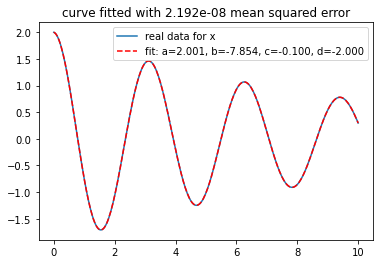

In [4]:
popt, pcov = curve_fit(candidate_function, t, data[:, 0])
mse = ((data[:, 0] - candidate_function(t, *popt))**2).mean()

plt.plot(t, data[:, 0], label='real data for x')
plt.plot(t, candidate_function(t, *popt), 'r--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.legend()
plt.title(f'curve fitted with {mse:{3}.{4}} mean squared error')
plt.show()

The data was fitted perfectly. This allowed us to fit only the `x` variable but we can do the exact same thing for `y`.

### ODE discovering

Now we will use the dynamic systems approach. For this we will run a sparse regression with a maximum degree of 1 for the candidate functions to avoid having lots of zeros in the output. The result is just below.

In [5]:
import codebase
from codebase.sparse_regression import *
from codebase.utils import *

In [6]:
derivative = True # means we will be guessing the derivative rather than the new state

# We first need to split the data into features and targets
targets, m = make_targets(data, derivative=derivative, timestep=t[1])

# Then we augment the features (using a max degree of 1 to avoid having lots of zeros in the result)
X, _ = make_polynomials(m, max_degree=1)

# Now we can run the sparse regression
weights, _ = sparse_regression(X, targets, cutoff=1e-3)

# Finally we can show the results
show_weights(weights, derivative=derivative)

| function   |   $\dot{x}$ |   $\dot{y}$ |
|:-----------|------------:|------------:|
| $1$        |   0         |   0         |
| $ x$       |  -0.0999018 |  -1.99904   |
| $ y$       |   1.99899   |  -0.0999838 |

Now we have to possibilities, we can either solve this equation analytically or numerically or we can also use the iterative version of the sparse regression and generate a trajectory. Let's try the second possibility.

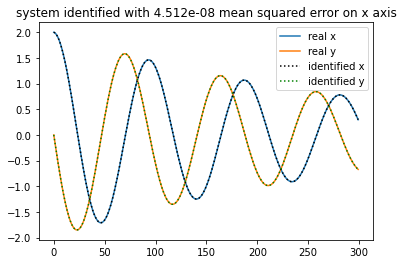

In [7]:
targets, m = make_targets(data, derivative=False) 
weights, _ = sparse_regression(X, targets, cutoff=1e-3)

# Now we can do the integration
guess = naive_integrate(weights, data[0], nb_iterations=300)

mse = ((data - guess)**2).mean()

plt.plot(data[:, 0], label='real x'); plt.plot(data[:, 1], label='real y')                             
plt.plot(guess[:, 0], 'k:', label='identified x'); plt.plot(guess[:, 1], 'g:', label='identified y')
plt.title(f'system identified with {mse:{3}.{4}} mean squared error on x axis')
plt.legend() 
plt.show()

Here as well we can say that the data was fitted perfectly.

### Comparaison

We can now plot the difference between the ground truth and the two models.

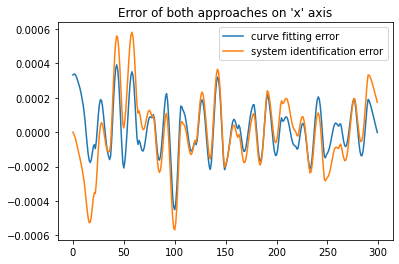

In [8]:
plt.plot(candidate_function(t, *popt) - data[:, 0] , label='curve fitting error')
plt.plot(guess[:, 0] - data[:, 0], label='system identification error')
plt.title("Error of both approaches on 'x' axis")
plt.legend() 
plt.show()

The error is more or less equivalent for both approaches and even if the indentification of the dynamics has some slightly higher peaks we can say that on this very simple problem both methods work equally well.

## Trying with COVID-19 data

Now that we used both approches on simulated data we can try to use it on the data from the epidemic. Here is a plot that shows the number of cumulative cases in France.

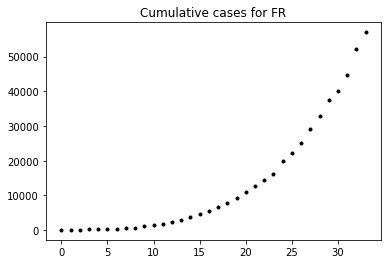

In [27]:
country = 'FR'

covid = pd.read_csv('C:/Users/kipr/Downloads/téléchargement.csv')
country_covid = covid[covid['geoId'] == country].copy()
country_covid.loc[:, 'dateRep'] = pd.to_datetime(country_covid['dateRep'], dayfirst=True)
values = np.cumsum(country_covid.sort_values('dateRep')[['cases']].values.squeeze())[60:]

plt.plot(values, 'k.')
plt.title(f'Cumulative cases for {country}')
plt.show()

We will define a simple logistic fuction that we will fit to the data. 
$$ f(x) = \frac{a}{1 + e^{b(x - c)}}$$
$a, b$ and $c$ are the learned parameters.

In [21]:
def logistic(t, a, b, c):
    return a/(1 + np.exp(b*(t - c)))

And now we can fit the data with both approaches.

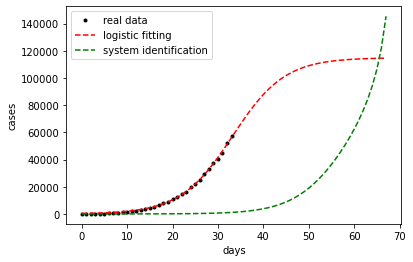

In [34]:
t = range(len(values)*2)

# Curve fitting
popt, pcov = curve_fit(logistic, t[:len(values)], values/max(values))

# System identification
targets, m = make_targets(values.reshape(-1, 1)/max(values))
X, _ = make_polynomials(m, max_degree=3)
weights, _ = sparse_regression(X, targets, cutoff=1e-2)
guess = naive_integrate(weights, np.array([0.00005]), nb_iterations=len(values)*2)

plt.plot(t[:len(values)], values, 'k.', label='real data')
plt.plot(t, logistic(t, *popt)*max(values), 'r--', label='logistic fitting')
plt.plot(t, guess*max(values), 'g--', label='system identification')
plt.legend(); plt.xlabel('days'); plt.ylabel('cases')
plt.title(f'')
plt.show()

The first thing we can notice is that the system identification approach gives way more optimistic results. The sparse regression algorithm is designed to minimize the error on the dataset but nothing prevents it from behaving as it likes outside of the domain. However in this case the algorithm sensed the fact that the growth will eventually stop and gave a totally possible prediction and this is already a remarkable thing.

We can have a look at the coefficients it identified (those are the coefficients of the normalized problem which means that it was rescaled so that its maximum value is 1):

In [30]:
show_weights(weights)

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |    0        |
| $ x$       |    1.1985   |
| $ x^2$     |   -0.167535 |
| $ x^3$     |    0.07547  |

Which means that according to the system identification algorithm the evolution of the cumulative cases in France so far followed something like:

$$x_{k+1} = 1.166 x_k + 0.0695 x_k^2 - 0.167 x_k^3$$

where $x_k$ is total number of cases in France divided by 40174 (because of the rescaling) for day $k$.

### Chinese case

China has already handled the pandemic on its territory and the curve has already finished its growth almost completely, thats why is is interesting to try to see what kind of underlying dynamics does the evolution have.

Here are the results of fitting the data with both approaches:

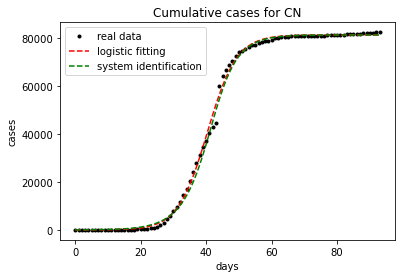

In [13]:
country = 'CN'

covid = pd.read_csv('C:/Users/kipr/Downloads/téléchargement.csv')
country_covid = covid[covid['geoId'] == country].copy()
country_covid.loc[:, 'dateRep'] = pd.to_datetime(country_covid['dateRep'], dayfirst=True)
values = np.cumsum(country_covid.sort_values('dateRep')[['cases']].values.squeeze())[:]

t = range(len(values))

# Curve fitting
popt, pcov = curve_fit(logistic, t, values/max(values))

# System identification
targets, m = make_targets(values.reshape(-1, 1)/max(values))
X, _ = make_polynomials(m, max_degree=4)
weights, _ = sparse_regression(X, targets, cutoff=1e-2)
guess = naive_integrate(weights, np.array([0.0004]), nb_iterations=len(values))

plt.plot(t, values, 'k.', label='real data')
plt.plot(t, logistic(t, *popt)*max(values), 'r--', label='logistic fitting')
plt.plot(t, guess*max(values), 'g--', label='system identification')
plt.legend(); plt.xlabel('days'); plt.ylabel('cases')
plt.title(f'Cumulative cases for {country}')
plt.show()

Both models fit quite well. Here are the coefficients of the identified system:

In [14]:
show_weights(weights)

| function   |   $x_{k+1}$ |
|:-----------|------------:|
| $1$        |    0        |
| $ x$       |    1.19714  |
| $ x^2$     |   -0.034257 |
| $ x^3$     |   -0.348803 |
| $ x^4$     |    0.183405 |

For this example the choice of the degree was arbitrary but it is interesting to see as well how the maximum degree affects the identification. The following plot does this comparison.

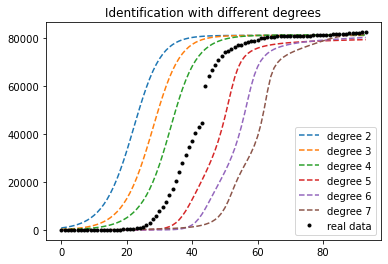

In [15]:
targets, m = make_targets(values.reshape(-1, 1)/max(values))

for degree, initial_value in zip(range(2, 8), [0.01, 0.003, 0.0017, 0.00000001, 0.0000000001, 0.0006]):
    X, _ = make_polynomials(m, max_degree=degree)
    weights, _ = sparse_regression(X, targets, cutoff=1e-2)
    guess = naive_integrate(weights, np.array([initial_value]), nb_iterations=len(values))
    plt.plot(t, guess*max(values), '--', label=f'degree {degree}')

plt.plot(t, values, 'k.', label='real data')
plt.legend(loc=4)
plt.title('Identification with different degrees')
plt.show()

The trajectories were desynchronized on purpose in order to have better visibility. From this plot it is clear that the higher the degree the more sophisticated is the model.  

## Conclusion

Both curve fitting and system identification through sparse regression are able to model different evolutions. The key difference is that the curve fitting is inherently limited by the candidate function whereas the system identification is much more flexible even with very simple polynomial terms.